In [1]:
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox
from matplotlib import cm
from dask.diagnostics import ProgressBar
import re

In [2]:
#Loading in the NWM mean annual rasters (Re_WY, P_WY, ET_WY, SR_WY) and the ADWR groundwater basin shapfile (GW_basin)

Re_WY = rxr.open_rasterio("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/Re/Re_M_WY.tif")
GW_basin = gpd.read_file("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/Groundwater_Basin/Groundwater_Basin.shp")
P_WY = rxr.open_rasterio("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/P/P_M_WY.tif")
ET_WY = rxr.open_rasterio("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/ET/ET_M_WY.tif")
SR_WY = rxr.open_rasterio("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/SR/SR_M_WY.tif")
SBII = rxr.open_rasterio("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/SBII/sbii_com10.tif")

NoData value: -9999.0


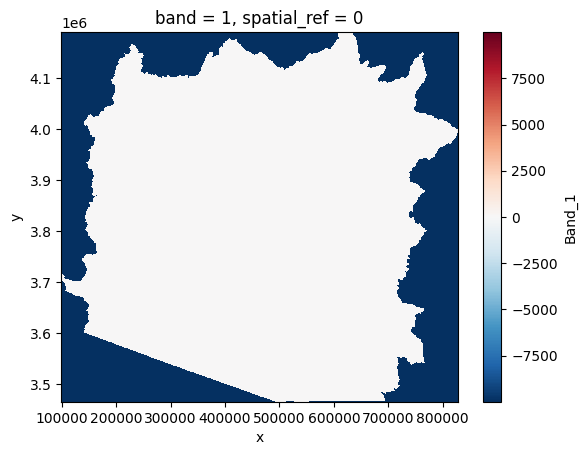

In [3]:
SBII.plot()
print("NoData value:", SBII.rio.nodata)

In [4]:
# Manually define the NoData value if needed
nodata_value = -9999

# Create a mask of all NoData pixels
nodata_mask = SBII == nodata_value

# Convert those to NaN for easier calculations
SBII_fix = SBII.where(SBII != nodata_value)

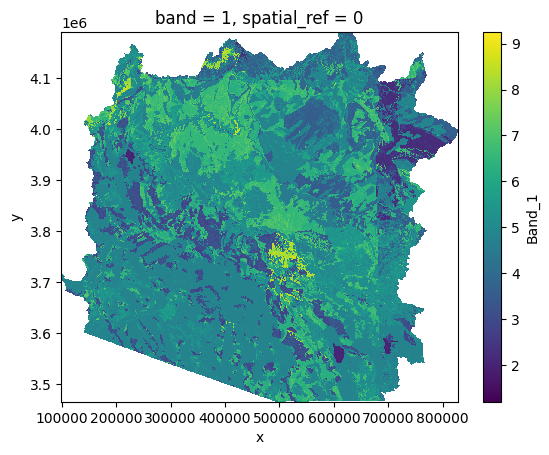

In [5]:
SBII_fix.plot()

In [6]:
num_nodata = nodata_mask.sum().item()
print(f"There are {num_nodata} NoData pixels.")

There are 601952 NoData pixels.


Text(0.5, 1.0, 'Long-term Mean (1981-2020) Annual Groundwater Recharge in Arizona')

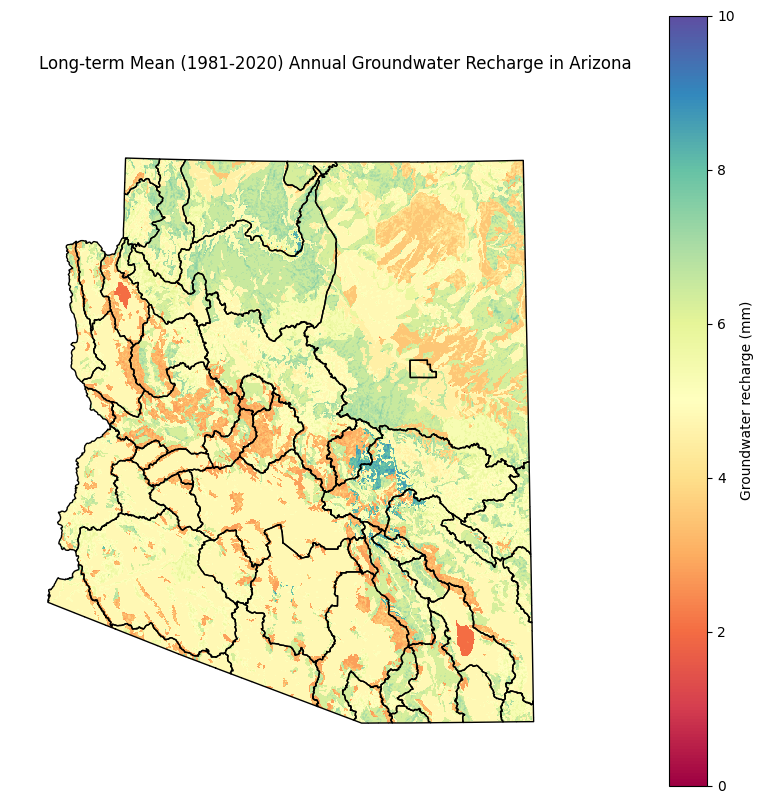

In [7]:
#playing around with SBII

#Creating a figure
fig, axes = plt.subplots(figsize=(10,10))

#Clipping the Re_WY raster to the GW basin shapefile (AZ Boundary)
SBII_clipped = SBII_fix.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)

 # treat -9999 as NoData -> set to NaN so it plots white
nodata_value = -9999
SBII_clip_fix = SBII_clipped.where(SBII_clipped != nodata_value)
SBII_clip_fix = SBII_clip_fix.where(np.isfinite(SBII_clip_fix))

    # colormap that paints NaNs (bad data) white
cmap = plt.get_cmap("Spectral").copy()
cmap.set_bad("white")

#Plotting the clipped Re_WY raster and the GW basin polygons
SBII_clip_fix.plot(ax=axes, cmap=cmap, vmin=0, vmax=10, cbar_kwargs={"label": "Groundwater recharge (mm)", "pad":0.01})
GW_basin.plot(ax=axes, facecolor="none", edgecolor="black" , linewidth=1)
axes.axis('off')
plt.title("Long-term Mean (1981-2020) Annual Groundwater Recharge in Arizona")

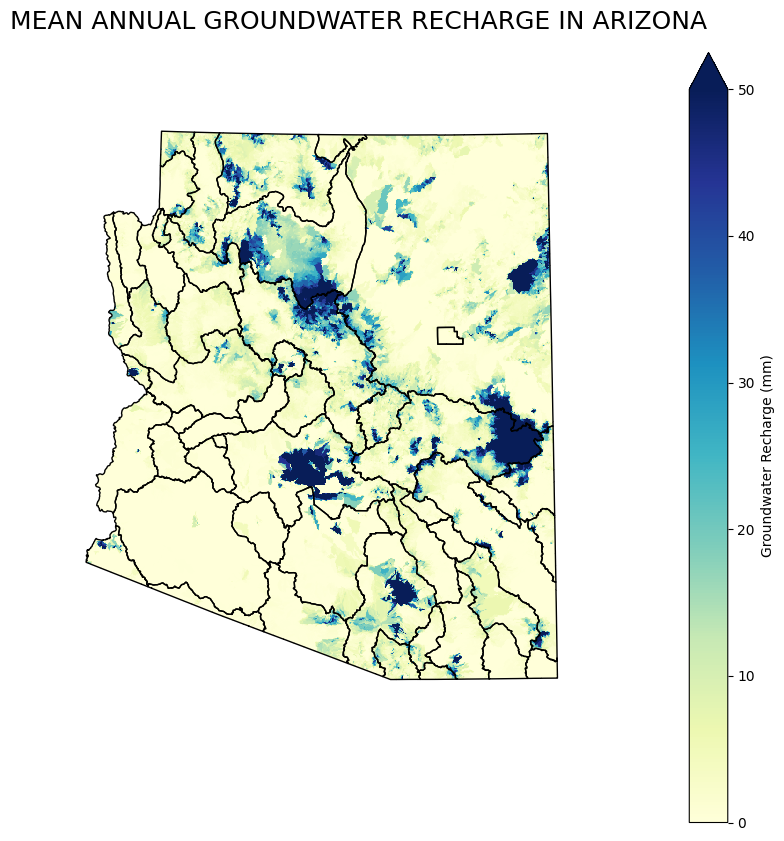

In [14]:
#playing around with Re

#Creating a figure
fig, axes = plt.subplots(figsize=(10,10))

#Clipping the Re_WY raster to the GW basin shapefile (AZ Boundary)
Re_clip = Re_WY.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)

 # treat -9999 as NoData -> set to NaN so it plots white
#nodata_value = -9999
#SBII_clip_fix = SBII_clipped.where(SBII_clipped != nodata_value)
#SBII_clip_fix = SBII_clip_fix.where(np.isfinite(SBII_clip_fix))

    # colormap that paints NaNs (bad data) white
cmap = plt.get_cmap("YlGnBu").copy()
cmap.set_bad("white")

#Plotting the clipped Re_WY raster and the GW basin polygons
Re_clip.plot(ax=axes, cmap=cmap, vmin=0, vmax=50, cbar_kwargs={"label": "Groundwater Recharge (mm)", "pad":0.01})
GW_basin.plot(ax=axes, facecolor="none", edgecolor="black" , linewidth=1)
axes.axis('off')
plt.title("MEAN ANNUAL GROUNDWATER RECHARGE IN ARIZONA", fontsize=18)
plt.savefig('AZ_GW_Re.png')

/workspaces/homework_marlanahinkley/.venv/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/workspaces/homework_marlanahinkley/.venv/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


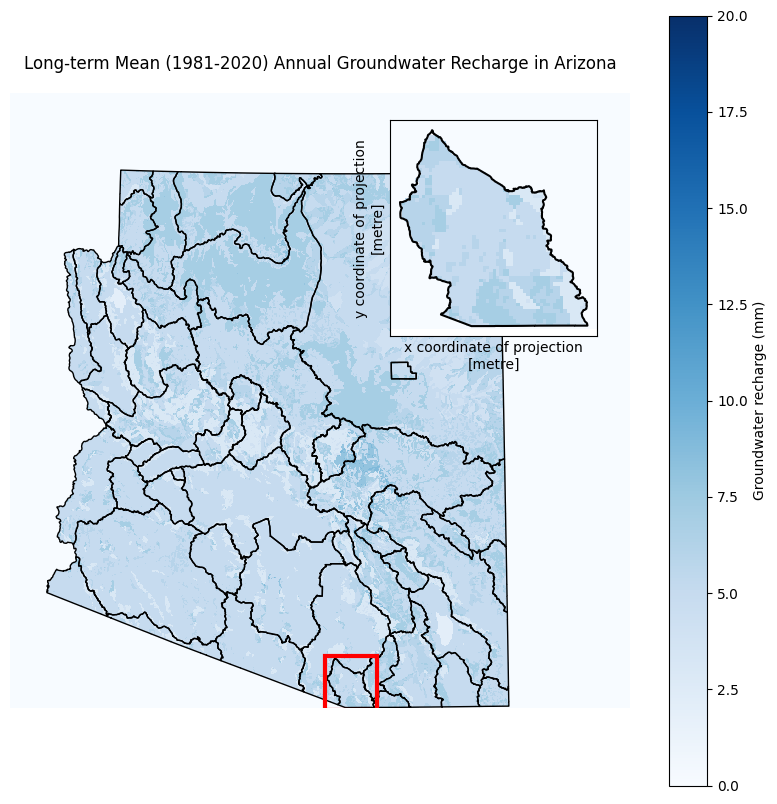

In [ ]:
#playing around

#Creating a figure
fig, axes = plt.subplots(figsize=(10,10))

#Clipping the Re_WY raster to the GW basin shapefile (AZ Boundary)
SBII_clipped = SBII_fix.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)

#Plotting the clipped Re_WY raster and the GW basin polygons
SBII_clipped.plot(ax=axes, cmap="Spectral", vmin=0, vmax=10, cbar_kwargs={"label": "Groundwater recharge (mm)"})
GW_basin.plot(ax=axes, facecolor="none", edgecolor="black" , linewidth=1)
axes.axis('off')
plt.title("Long-term Mean (1981-2020) Annual Groundwater Recharge in Arizona")

# create inset axes and plot zoomed raster + feature
axins = inset_axes(axes, width="35%", height="35%", loc="upper right", borderpad=2)

#Highlighting the Santa Cruz AMA groundwater basin
feature = GW_basin.loc[GW_basin['BASIN_NAME'] == 'SANTA CRUZ AMA']

#Clipping the raster to the Santa Cruz AMA groundwater basin
SBII_basin_clip = SBII.rio.clip(feature.geometry, GW_basin.crs, drop=False)
SBII_basin_clip.plot(ax=axins, cmap="Blues", vmin=0, vmax=20, add_colorbar=False)
feature.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=1.5)

# draw a red rectangle on the main map showing inset area
minx, miny, maxx, maxy = feature.total_bounds
pad = 0.05 * max(maxx - minx, maxy - miny)
rect = Rectangle((minx - pad, miny - pad),
                 (maxx - minx) + 2*pad,
                 (maxy - miny) + 2*pad,
                 edgecolor="red", facecolor="none", linewidth=3)
axes.add_patch(rect)
axins.set_xlim(minx - pad, maxx + pad)
axins.set_ylim(miny - pad, maxy + pad)
axins.set_xticks([])
axins.set_yticks([])
axins.set_title("")
axins.tick_params(labelleft=False, labelright=False, labeltop=False, labelbottom=False)
plt.savefig('Santa Cruz AMA.png')

In [8]:
#Switching the figure so that the inset is the full state of Arizona and the main plot is the specific basin. Note, AI helped me make this. 

def create_basin_Re_map_V2(basin):  # input: one-row GeoDataFrame for the basin
    fig, ax = plt.subplots(figsize=(10,15))

    feature = basin.copy()
    if feature.empty:
        print("empty feature"); return

    # MAIN: zoomed basin raster + basin polygon
    try:
        basin_clip = Re_WY.rio.clip(feature.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("basin clip failed:", e); return

     # compute vmin/vmax from clipped raster (ignore non-finite values)
    try:
        arr = basin_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr)
        if finite_mask.any():
            vmin = float(np.nanmin(arr[finite_mask]))
            vmax = float(np.nanmax(arr[finite_mask]))
        else:
            vmin, vmax = 0.0, 20.0
    except Exception:
        vmin, vmax = 0.0, 20.0
    
    
    basin_clip.plot(ax=ax, add_labels = False, cmap="YlGnBu", vmin=0, vmax=20, cbar_kwargs={"label": "Basin Mean Annual\nGroundwater Recharge (mm)", "pad":0.0001})
    feature.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

    # zoom main axes to basin bounds
    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.axis("off")
    Re_title = str(feature.iloc[0].get('BASIN_NAME', 'Basin'))
    ax.set_title(f"{Re_title}\nMEAN ANNUAL GROUNDWATER RECHARGE", loc="left", fontsize=18)

   
    # INSET: full state context placed to the right (bbox_to_anchor must be a 4-tuple when using relative width/height)
    # bbox=(x0, y0, width_frac, height_frac) in axes fraction coordinates
    
    inset_bbox = (1, 0.5, 0.75, 0.75)
    axins = inset_axes(
        ax,
        width="75%", height="75%",
        loc="upper right",
        bbox_to_anchor=inset_bbox,
        bbox_transform=ax.transAxes,
        borderpad=0
    )
    try:
        state_clip = Re_WY.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("state clip failed:", e); state_clip = Re_WY  # fallback


    # compute vmin/vmax from state clipped raster (ignore non-finite values)
    try:
        arr_state = state_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr_state)
        if finite_mask.any():
            vmin_state = float(np.nanmin(arr_state[finite_mask]))
            vmax_state = float(np.nanmax(arr_state[finite_mask]))
        else:
            vmin_state, vmax_state = 0.0, 20.0
    except Exception:
        vmin_state, vmax_state = 0.0, 20.0

    # plot state raster & basin outlines in inset
    im_inset = state_clip.plot(ax=axins, cmap="YlGnBu", vmin=0, vmax=50, add_colorbar=False)
    GW_basin.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=0.6)
    
    #Adding colorbar for the inset
    cax_inset = inset_axes(axins, width="10%",  # small width
                       height="100%",  # same height as inset
                       loc='center right',
                       borderpad=0)
    cbar_inset = fig.colorbar(im_inset, cax=cax_inset)
    cbar_inset.set_label("Statewide Mean Annual\nGroundwater Recharge (mm)", fontsize=6)
    cbar_inset.ax.tick_params(labelsize=6)   
    
    # draw red rectangle on inset showing basin location
    rect = Rectangle((minx - pad, miny - pad),
                     (maxx - minx) + 2 * pad,
                     (maxy - miny) + 2 * pad,
                     edgecolor="red", facecolor="none", linewidth=4)
    axins.add_patch(rect)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.set_title("")

    # save and close
    basin_name = str(feature.iloc[0].get('BASIN_NAME', 'basin')).strip()
    safe = re.sub(r'[^A-Za-z0-9_-]+', '_', basin_name).strip('_')[:80] or "basin"
    plt.savefig(f"{safe}_Re.png", bbox_inches="tight", dpi=200)
    plt.close(fig)



In [9]:
basin_gdf = GW_basin.loc[GW_basin['BASIN_NAME'] == 'HUALAPAI VALLEY INA']



In [10]:
create_basin_Re_map_V2(basin_gdf)

In [11]:
#Changing create_basin_Re_map_V2 to create maps for precip
def create_basin_P_map_V2(basin):  # input: one-row GeoDataFrame for the basin
    fig, ax = plt.subplots(figsize=(10,15))

    feature = basin.copy()
    if feature.empty:
        print("empty feature"); return

    # MAIN: zoomed basin raster + basin polygon
    try:
        basin_clip = P_WY.rio.clip(feature.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("basin clip failed:", e); return

     # compute vmin/vmax from clipped raster (ignore non-finite values)
    try:
        arr = basin_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr)
        if finite_mask.any():
            vmin = float(np.nanmin(arr[finite_mask]))
            vmax = float(np.nanmax(arr[finite_mask]))
        else:
            vmin, vmax = 0.0, 20.0
    except Exception:
        vmin, vmax = 0.0, 20.0
    
    
    basin_clip.plot(ax=ax, add_labels = False, cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Basin Mean Annual\nPrecipitation (mm)", "pad":0.001})
    feature.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

    # zoom main axes to basin bounds
    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.axis("off")
    P_title = str(feature.iloc[0].get('BASIN_NAME', 'Basin'))
    ax.set_title(f"{P_title}\nMEAN ANNUAL PRECIPITATION", loc="left", fontsize=18)

   
    # INSET: full state context placed to the right (bbox_to_anchor must be a 4-tuple when using relative width/height)
    # bbox=(x0, y0, width_frac, height_frac) in axes fraction coordinates
    
    inset_bbox = (1, 0.5, 0.75, 0.75)
    axins = inset_axes(
        ax,
        width="75%", height="75%",
        loc="upper right",
        bbox_to_anchor=inset_bbox,
        bbox_transform=ax.transAxes,
        borderpad=0
    )
    try:
        state_clip = P_WY.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("state clip failed:", e); state_clip = P_WY  # fallback


    # compute vmin/vmax from state clipped raster (ignore non-finite values)
    try:
        arr_state = state_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr_state)
        if finite_mask.any():
            vmin_state = float(np.nanmin(arr_state[finite_mask]))
            vmax_state = float(np.nanmax(arr_state[finite_mask]))
        else:
            vmin_state, vmax_state = 0.0, 20.0
    except Exception:
        vmin_state, vmax_state = 0.0, 20.0

    # plot state raster & basin outlines in inset
    im_inset = state_clip.plot(ax=axins, cmap="YlGnBu", vmin=vmin_state, vmax=vmax_state, add_colorbar=False)
    GW_basin.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=0.6)
    
    #Adding colorbar for the inset
    cax_inset = inset_axes(axins, width="10%",  # small width
                       height="100%",  # same height as inset
                       loc='center right',
                       borderpad=0)
    cbar_inset = fig.colorbar(im_inset, cax=cax_inset)
    cbar_inset.set_label("Statewide Mean Annual\nPrecipitation (mm)", fontsize=6)
    cbar_inset.ax.tick_params(labelsize=6)   
    
    # draw red rectangle on inset showing basin location
    rect = Rectangle((minx - pad, miny - pad),
                     (maxx - minx) + 2 * pad,
                     (maxy - miny) + 2 * pad,
                     edgecolor="red", facecolor="none", linewidth=4)
    axins.add_patch(rect)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.set_title("")

    # save and close
    basin_name = str(feature.iloc[0].get('BASIN_NAME', 'basin')).strip()
    safe = re.sub(r'[^A-Za-z0-9_-]+', '_', basin_name).strip('_')[:80] or "basin"
    plt.savefig(f"{safe}_P.png", bbox_inches="tight", dpi=200)
    plt.close(fig)

In [12]:
create_basin_P_map_V2(basin_gdf)

In [ ]:
#Create maps for ET
def create_basin_ET_map_V2(basin):  # input: one-row GeoDataFrame for the basin
    fig, ax = plt.subplots(figsize=(10,10))

    feature = basin.copy()
    if feature.empty:
        print("empty feature"); return

    # MAIN: zoomed basin raster + basin polygon
    try:
        basin_clip = ET_WY.rio.clip(feature.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("basin clip failed:", e); return

     # compute vmin/vmax from clipped raster (ignore non-finite values)
    try:
        arr = basin_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr)
        if finite_mask.any():
            vmin = float(np.nanmin(arr[finite_mask]))
            vmax = float(np.nanmax(arr[finite_mask]))
        else:
            vmin, vmax = 0.0, 20.0
    except Exception:
        vmin, vmax = 0.0, 20.0
    
    
    basin_clip.plot(ax=ax, add_labels = False, cmap="YlOrRd", vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Basin Mean Annual\nEvapotranspiration (mm)","pad":0.01})
    feature.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

    # zoom main axes to basin bounds
    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.axis("off")
    ET_title = str(feature.iloc[0].get('BASIN_NAME', 'Basin'))
    ax.set_title(f"{ET_title}\nMEAN ANNUAL EVAPOTRANSPIRATION", loc="left")

   
    # INSET: full state context placed to the right (bbox_to_anchor must be a 4-tuple when using relative width/height)
    # bbox=(x0, y0, width_frac, height_frac) in axes fraction coordinates
    
    inset_bbox = (1, 0.5, 0.75, 0.75)
    axins = inset_axes(
        ax,
        width="75%", height="75%",
        loc="upper right",
        bbox_to_anchor=inset_bbox,
        bbox_transform=ax.transAxes,
        borderpad=0
    )
    try:
        state_clip = ET_WY.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("state clip failed:", e); state_clip = ET_WY  # fallback


    # compute vmin/vmax from state clipped raster (ignore non-finite values)
    try:
        arr_state = state_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr_state)
        if finite_mask.any():
            vmin_state = float(np.nanmin(arr_state[finite_mask]))
            vmax_state = float(np.nanmax(arr_state[finite_mask]))
        else:
            vmin_state, vmax_state = 0.0, 20.0
    except Exception:
        vmin_state, vmax_state = 0.0, 20.0

    # plot state raster & basin outlines in inset
    im_inset = state_clip.plot(ax=axins, cmap="YlOrRd", vmin=vmin_state, vmax=vmax_state, add_colorbar=False)
    GW_basin.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=0.6)
    
    #Adding colorbar for the inset
    cax_inset = inset_axes(axins, width="10%",  # small width
                       height="100%",  # same height as inset
                       loc='center right',
                       borderpad=0)
    cbar_inset = fig.colorbar(im_inset, cax=cax_inset)
    cbar_inset.set_label("Statewide Mean Annual\nEvapotranspiration (mm)", fontsize=6)
    cbar_inset.ax.tick_params(labelsize=6)   
    
    # draw red rectangle on inset showing basin location
    rect = Rectangle((minx - pad, miny - pad),
                     (maxx - minx) + 2 * pad,
                     (maxy - miny) + 2 * pad,
                     edgecolor="red", facecolor="none", linewidth=2)
    axins.add_patch(rect)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.set_title("")

    # save and close
    basin_name = str(feature.iloc[0].get('BASIN_NAME', 'basin')).strip()
    safe = re.sub(r'[^A-Za-z0-9_-]+', '_', basin_name).strip('_')[:80] or "basin"
    plt.savefig(f"{safe}_ET.png", bbox_inches="tight", dpi=200)
    plt.close(fig)

In [10]:
create_basin_ET_map_V2(basin_gdf)

In [ ]:
#Create maps for SR
def create_basin_SR_map_V2(basin):  # input: one-row GeoDataFrame for the basin
    fig, ax = plt.subplots(figsize=(10,10))

    feature = basin.copy()
    if feature.empty:
        print("empty feature"); return

    # MAIN: zoomed basin raster + basin polygon
    try:
        basin_clip = SR_WY.rio.clip(feature.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("basin clip failed:", e); return

     # compute vmin/vmax from clipped raster (ignore non-finite values)
    try:
        arr = basin_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr)
        if finite_mask.any():
            vmin = float(np.nanmin(arr[finite_mask]))
            vmax = float(np.nanmax(arr[finite_mask]))
        else:
            vmin, vmax = 0.0, 20.0
    except Exception:
        vmin, vmax = 0.0, 20.0
    
    
    basin_clip.plot(ax=ax, add_labels = False, cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Basin Mean Annual\nSurface Runoff (mm)", "pad":0.01})
    feature.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

    # zoom main axes to basin bounds
    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.axis("off")
    SR_title = str(feature.iloc[0].get('BASIN_NAME', 'Basin'))
    ax.set_title(f"{SR_title}\nMEAN ANNUAL SURFACE RUNOFF", loc="left")

   
    # INSET: full state context placed to the right (bbox_to_anchor must be a 4-tuple when using relative width/height)
    # bbox=(x0, y0, width_frac, height_frac) in axes fraction coordinates
    
    inset_bbox = (1, 0.5, 0.6, 0.6)
    axins = inset_axes(
        ax,
        width="60%", height="60%",
        loc="upper right",
        bbox_to_anchor=inset_bbox,
        bbox_transform=ax.transAxes,
        borderpad=0
    )
    try:
        state_clip = SR_WY.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("state clip failed:", e); state_clip = ET_WY  # fallback


    # compute vmin/vmax from state clipped raster (ignore non-finite values)
    try:
        arr_state = state_clip.squeeze().values  # handle (band,y,x) -> (y,x)
        finite_mask = np.isfinite(arr_state)
        if finite_mask.any():
            vmin_state = float(np.nanmin(arr_state[finite_mask]))
            vmax_state = float(np.nanmax(arr_state[finite_mask]))
        else:
            vmin_state, vmax_state = 0.0, 20.0
    except Exception:
        vmin_state, vmax_state = 0.0, 20.0

    # plot state raster & basin outlines in inset
    im_inset = state_clip.plot(ax=axins, cmap="YlGnBu", vmin=vmin_state, vmax=vmax_state, add_colorbar=False)
    GW_basin.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=0.6)
    
    #Adding colorbar for the inset
    cax_inset = inset_axes(axins, width="10%",  # small width
                       height="100%",  # same height as inset
                       loc='center right',
                       borderpad=0)
    cbar_inset = fig.colorbar(im_inset, cax=cax_inset)
    cbar_inset.set_label("Statewide Mean Annual\nSurface Runoff (mm)", fontsize=6)
    cbar_inset.ax.tick_params(labelsize=6)   
    
    # draw red rectangle on inset showing basin location
    rect = Rectangle((minx - pad, miny - pad),
                     (maxx - minx) + 2 * pad,
                     (maxy - miny) + 2 * pad,
                     edgecolor="red", facecolor="none", linewidth=2)
    axins.add_patch(rect)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.set_title("")

    # save and close
    basin_name = str(feature.iloc[0].get('BASIN_NAME', 'basin')).strip()
    safe = re.sub(r'[^A-Za-z0-9_-]+', '_', basin_name).strip('_')[:80] or "basin"
    plt.savefig(f"{safe}_SR.png", bbox_inches="tight", dpi=200)
    plt.close(fig)

In [22]:
create_basin_SR_map_V2(basin_gdf)

In [56]:
#creating an image for SBII
def create_basin_SBII_map_V2(basin):  # input: one-row GeoDataFrame for the basin
    fig, ax = plt.subplots(figsize=(10,15))

    feature = basin.copy()
    if feature.empty:
        print("empty feature"); return

    # Manually define the NoData value if needed
    #nodata_value = -9999

    # Create a mask of all NoData pixels
    #nodata_mask = SBII == nodata_value

    # Convert those to NaN for easier calculations
    #SBII_fix = SBII.where(SBII != nodata_value) 
    
    # MAIN: zoomed basin raster + basin polygon
    try:
        basin_clip = SBII_fix.rio.clip(feature.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("basin clip failed:", e); return
    
    # treat -9999 as NoData -> set to NaN so it plots white
    nodata_value = -9999
    basin_clip = basin_clip.where(basin_clip != nodata_value)
    basin_clip = basin_clip.where(np.isfinite(basin_clip))

    # colormap that paints NaNs (bad data) white
    cmap = plt.get_cmap("Spectral").copy()
    cmap.set_bad("white")


    basin_clip.plot(ax=ax, add_labels = False, cmap=cmap, vmin = 0, vmax = 10, cbar_kwargs={"label": "Basin SBII", "pad":0.0001})
    feature.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

    # zoom main axes to basin bounds
    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.axis("off")
    SR_title = str(feature.iloc[0].get('BASIN_NAME', 'Basin'))
    ax.set_title(f"{SR_title}\nSUBSURFACE INFILTRATION CAPACITY INDEX (SBII)", loc="left", fontsize=18)

   
    # INSET: full state context placed to the right (bbox_to_anchor must be a 4-tuple when using relative width/height)
    # bbox=(x0, y0, width_frac, height_frac) in axes fraction coordinates
    
    inset_bbox = (1, 0.5, 0.75, 0.75)
    axins = inset_axes(
        ax,
        width="75%", height="75%",
        loc="upper right",
        bbox_to_anchor=inset_bbox,
        bbox_transform=ax.transAxes,
        borderpad=0
    )
    try:
        state_clip = SBII_fix.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)
    except Exception as e:
        print("state clip failed:", e); state_clip = SBII_fix  # fallback

# mask state nodata too
    state_clip = state_clip.where(state_clip != nodata_value)
    state_clip = state_clip.where(np.isfinite(state_clip))

    # plot state raster & basin outlines in inset
    im_inset = state_clip.plot(ax=axins, cmap=cmap, vmin = 0, vmax =10, add_colorbar=False)
    GW_basin.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=0.6)
    
    #Adding colorbar for the inset
    cax_inset = inset_axes(axins, width="10%",  # small width
                       height="100%",  # same height as inset
                       loc='center right',
                       borderpad=0)
    cbar_inset = fig.colorbar(im_inset, cax=cax_inset)
    cbar_inset.set_label("Statewide SBII", fontsize=6)
    cbar_inset.ax.tick_params(labelsize=6)   
    
    # draw red rectangle on inset showing basin location
    rect = Rectangle((minx - pad, miny - pad),
                     (maxx - minx) + 2 * pad,
                     (maxy - miny) + 2 * pad,
                     edgecolor="red", facecolor="none", linewidth=4)
    axins.add_patch(rect)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.set_title("")

    # save and close
    basin_name = str(feature.iloc[0].get('BASIN_NAME', 'basin')).strip()
    safe = re.sub(r'[^A-Za-z0-9_-]+', '_', basin_name).strip('_')[:80] or "basin"
    plt.savefig(f"{safe}_SBII.png", bbox_inches="tight", dpi=200)
    plt.close(fig)

In [57]:
create_basin_SBII_map_V2(basin_gdf)

In [48]:
basin_clip.plot()

NameError: name 'basin_clip' is not defined

In [ ]:
#Trying combined function for all four maps - doesn't work great
#def create_basin_maps_V2(basin, outdir=None):
    """
    Create four images (Re, P, ET, SR) for one basin GeoDataFrame (one-row).
    Saves files to cwd or outdir if provided.
    """
    import os
    maps = {
        "Re": {"raster": Re_WY, "cmap": "YlGnBu", "title": "MEAN ANNUAL GROUNDWATER RECHARGE", "suffix":"Re"},
        "P":  {"raster": P_WY,  "cmap": "YlGnBu", "title": "MEAN ANNUAL PRECIPITATION",    "suffix":"P"},
        "ET": {"raster": ET_WY, "cmap": "YlOrRd", "title": "MEAN ANNUAL EVAPOTRANSPIRATION","suffix":"ET"},
        "SR": {"raster": SR_WY, "cmap": "YlGnBu", "title": "MEAN ANNUAL SURFACE RUNOFF",   "suffix":"SR"},
    }

    feature = basin.copy()
    if feature.empty:
        print("empty feature"); return

    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    safe_name = re.sub(r'[^A-Za-z0-9_-]+', '_', str(feature.iloc[0].get('BASIN_NAME','basin'))).strip('_')[:80] or "basin"
    outdir = outdir or "."

    for key, cfg in maps.items():
        raster = cfg["raster"]
        cmap = cfg["cmap"]
        title = cfg["title"]
        suffix = cfg["suffix"]

        fig, ax = plt.subplots(figsize=(10,10))

        # clip basin and state (state used for context inset)
        try:
            basin_clip = raster.rio.clip(feature.geometry, GW_basin.crs, drop=False)
        except Exception as e:
            print(f"{key} basin clip failed:", e); plt.close(fig); continue
        try:
            state_clip = raster.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)
        except Exception as e:
            print(f"{key} state clip failed:", e); state_clip = raster

        # compute vmin/vmax from finite values in both arrays for consistent mapping
        try:
            arr_b = basin_clip.squeeze().values
            arr_s = state_clip.squeeze().values
            vals = np.concatenate([np.ravel(arr_b[np.isfinite(arr_b)]), np.ravel(arr_s[np.isfinite(arr_s)])]) if np.isfinite(arr_b).any() or np.isfinite(arr_s).any() else np.array([])
            if vals.size:
                vmin, vmax = float(np.nanmin(vals)), float(np.nanmax(vals))
            else:
                vmin, vmax = 0.0, 20.0
        except Exception:
            vmin, vmax = 0.0, 20.0

        # main (zoomed) plot
        basin_clip.plot(ax=ax, add_labels=False, cmap=cmap, vmin=vmin, vmax=vmax,
                        cbar_kwargs={"label": f"Basin {title}"})
        feature.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)
        ax.set_xlim(minx - pad, maxx + pad)
        ax.set_ylim(miny - pad, maxy + pad)
        ax.axis("off")
        ax.set_title(f"{safe_name}\n{title}", loc="left")

        # INSET: full state context to the right (bbox_to_anchor is 4-tuple)
        inset_bbox = (1.02, 0.5, 0.30, 0.30)  # (x0, y0, width_frac, height_frac) in axes fraction coords
        axins = inset_axes(
            ax,
            width="30%", height="30%",
            loc="center left",
            bbox_to_anchor=inset_bbox,
            bbox_transform=ax.transAxes,
            borderpad=0
        )

        im_inset = state_clip.plot(ax=axins, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
        GW_basin.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=0.6)

        # draw red rectangle on inset showing basin location
        rect = Rectangle((minx - pad, miny - pad),
                         (maxx - minx) + 2 * pad,
                         (maxy - miny) + 2 * pad,
                         edgecolor="red", facecolor="none", linewidth=2)
        axins.add_patch(rect)
        axins.set_xticks([]); axins.set_yticks([]); axins.set_title("Arizona (context)")
        axins.set_xlabel(""); axins.set_ylabel("")

        # colorbar for inset placed just to the right of inset_bbox
        small_gap = 0.015
        cbar_bbox = (inset_bbox[0] + inset_bbox[2] + small_gap, inset_bbox[1], 0.02, inset_bbox[3])
        cax = inset_axes(
            ax,
            width=f"{cbar_bbox[2]*100}%", height=f"{cbar_bbox[3]*100}%",
            loc="center left",
            bbox_to_anchor=cbar_bbox,
            bbox_transform=ax.transAxes,
            borderpad=0
        )

        # choose mappable from inset for colorbar
        mappable = None
        if getattr(axins, "get_images", None) and axins.get_images():
            mappable = axins.get_images()[0]
        elif getattr(axins, "collections", None) and axins.collections:
            mappable = axins.collections[0]

        if mappable is not None:
            cb = fig.colorbar(mappable, cax=cax, orientation="vertical", ticks=[vmin, vmax])
            cb.set_label(f"Statewide {title}", fontsize=8)
            cb.ax.tick_params(labelsize=8)
        else:
            cax.axis("off")

        # save
        outfn = os.path.join(outdir, f"{safe_name}_{suffix}.png")
        plt.savefig(outfn, bbox_inches="tight", dpi=200)
        plt.close(fig)
        print("saved:", outfn)

In [ ]:
#create_basin_maps_V2(basin_gdf)

saved: ./SANTA_CRUZ_AMA_Re.png
saved: ./SANTA_CRUZ_AMA_P.png
saved: ./SANTA_CRUZ_AMA_ET.png
saved: ./SANTA_CRUZ_AMA_SR.png


In [ ]:
#def create_basin_Re_map(basin): #input the geodataframe of the basin to plot
    #Creating a figure
    fig, axes = plt.subplots(figsize=(10,10))

    #Clipping the Re_WY raster to the GW basin shapefile (AZ Boundary)
    Re_WY_clipped = Re_WY.rio.clip(GW_basin.geometry, GW_basin.crs, drop=False)

    #Plotting the clipped Re_WY raster and the GW basin polygons
    Re_WY_clipped.plot(ax=axes, cmap="Blues", vmin=0, vmax=20, cbar_kwargs={"label": "Groundwater recharge (mm)"})
    GW_basin.plot(ax=axes, facecolor="none", edgecolor="black" , linewidth=1)
    axes.axis('off')
    plt.title("Long-term Mean (1981-2020) Annual Groundwater Recharge in Arizona")
        
    # create inset axes and plot zoomed raster + feature
    axins = inset_axes(axes, width="35%", height="35%", loc="upper right", borderpad=2)

    #Highlighting the specified groundwater basin
    feature = basin
    #if feature.empty:
        # fallback: try alternative column names or choose first feature
        #feature = GW_basin.iloc[[0]]

    #Clipping the raster to the specified groundwater basin
    Re_WY_basin_clip = Re_WY.rio.clip(feature.geometry, GW_basin.crs, drop=False)
    Re_WY_basin_clip.plot(ax=axins, cmap="Blues", vmin=0, vmax=20, add_colorbar=False)
    feature.plot(ax=axins, facecolor="none", edgecolor="black", linewidth=1.5)

    # draw a red rectangle on the main map showing inset area
    minx, miny, maxx, maxy = feature.total_bounds
    pad = 0.05 * max(maxx - minx, maxy - miny)
    rect = Rectangle((minx - pad, miny - pad),
                     (maxx - minx) + 2*pad,
                     (maxy - miny) + 2*pad,
                     edgecolor="red", facecolor="none", linewidth=3)
    axes.add_patch(rect)
    
    axins.set_xlim(minx - pad, maxx + pad)
    axins.set_ylim(miny - pad, maxy + pad)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_title("")
    axins.tick_params(labelleft=False, labelright=False, labeltop=False, labelbottom=False)
    basin_name = feature.loc[0,'BASIN_NAME']
    plt.savefig(f"{basin_name}.png")

In [ ]:
basin_gdf = GW_basin.loc[GW_basin['BASIN_NAME'] == 'SANTA CRUZ AMA']
create_basin_Re_map_V2(basin_gdf)


In [26]:
basin_names = GW_basin['BASIN_NAME'].unique()

basin_names_short = ['SANTA CRUZ AMA', 'SAN BERNARDINO VALLEY', 'SAN RAFAEL',
       'TIGER WASH', 'VIRGIN RIVER', 'SHIVWITS PLATEAU', 'KANAB PLATEAU',
       'LITTLE COLORADO RIVER PLATEAU']


In [28]:
for b in basin_names_short:
    basin_gdf = GW_basin[GW_basin['BASIN_NAME'] == b]
    create_basin_Re_map_V2(basin_gdf)
    create_basin_ET_map_V2(basin_gdf)
    create_basin_P_map_V2(basin_gdf)
    create_basin_SR_map_V2(basin_gdf)

: 

In [36]:
basin_names

array(['SANTA CRUZ AMA', 'SAN BERNARDINO VALLEY', 'SAN RAFAEL',
       'TIGER WASH', 'VIRGIN RIVER', 'SHIVWITS PLATEAU', 'KANAB PLATEAU',
       'LITTLE COLORADO RIVER PLATEAU', 'PARIA', 'GRAND WASH',
       'COCONINO PLATEAU', 'HUALAPAI VALLEY INA', 'MEADVIEW',
       'DETRITAL VALLEY', 'LAKE MOHAVE', 'PEACH SPRINGS', 'VERDE RIVER',
       'BIG SANDY', 'SACRAMENTO VALLEY', 'JOSEPH CITY INA',
       'BILL WILLIAMS', 'PRESCOTT AMA', 'LAKE HAVASU', 'AGUA FRIA',
       'UPPER HASSAYAMPA', 'TONTO CREEK', 'SALT RIVER', 'PARKER',
       'BUTLER VALLEY', 'MCMULLEN VALLEY', 'PHOENIX AMA',
       'RANEGRAS PLAIN', 'MORENCI', 'HARQUAHALA INA', 'SAFFORD',
       'LOWER GILA', 'BONITA CREEK', 'LOWER SAN PEDRO', 'PINAL AMA',
       'DRIPPING SPRING WASH', 'GILA BEND', 'DONNELLY WASH',
       'DUNCAN VALLEY', 'ARAVAIPA CANYON', 'YUMA', 'TUCSON AMA',
       'WILLCOX AMA', 'SAN SIMON WASH', 'UPPER SAN PEDRO',
       'WESTERN MEXICAN DRAINAGE', 'CIENEGA CREEK', 'DOUGLAS AMA'],
      dtype=object)

In [48]:
basin_gdf

,OBJECTID,BASIN_NAME,NAME_ABBR,BASIN_NA_1,Shape__Are,Shape__Len,geometry
0,2,SANTA CRUZ AMA,SCA,SANTA CRUZ AMA,1.853991e+09,227784.354771,"POLYGON ((481155.982 3524735.269, 481185.919 3..."


In [6]:
GW_basin

,OBJECTID,BASIN_NAME,NAME_ABBR,BASIN_NA_1,Shape__Are,Shape__Len,geometry
0,2,SANTA CRUZ AMA,SCA,SANTA CRUZ AMA,1.853991e+09,2.277844e+05,"POLYGON ((481155.982 3524735.269, 481185.919 3..."
1,3,SAN BERNARDINO VALLEY,SBV,SAN BERNADINO VALLEY BASIN,1.003345e+09,1.510856e+05,"POLYGON ((655800.905 3501799.2, 655817.405 350..."
2,4,SAN RAFAEL,SRF,SAN RAFAEL BASIN,5.924155e+08,1.282860e+05,"POLYGON ((540754.845 3485904.667, 540769.72 34..."
3,5,TIGER WASH,TIG,TIGER WASH BASIN,1.919046e+08,6.321529e+04,"POLYGON ((298757.482 3749840.931, 299671.513 3..."
4,6,VIRGIN RIVER,VRG,VIRGIN RIVER BASIN,1.122834e+09,1.720228e+05,"POLYGON ((262297.846 4067969.893, 262183.596 4..."
5,7,SHIVWITS PLATEAU,SHV,SHIVWITS PLATEAU BASIN,4.715421e+09,4.547140e+05,"POLYGON ((266705.006 4098083.938, 267681.1 409..."
6,8,KANAB PLATEAU,KAN,KANAB PLATEAU BASIN,1.099942e+10,6.359708e+05,"POLYGON ((295986.747 4097329.16, 297040.621 40..."
7,9,LITTLE COLORADO RIVER PLATEAU,LCR,LITTLE COLORADO RIVER PLATEAU BASIN,6.868391e+10,1.441487e+06,"POLYGON ((449659.816 4077660.86, 449713.441 40..."
8,10,PARIA,PAR,PARIA BASIN,1.057523e+09,1.984457e+05,"POLYGON ((410740.654 4095341.163, 410957.216 4..."
9,11,GRAND WASH,GWA,GRAND WASH BASIN,2.482909e+09,2.487586e+05,"POLYGON ((262297.846 4067969.893, 262275.221 4..."


In [49]:
feature.total_bounds

array([ 471615.7149, 3466438.627 ,  527376.6767, 3524735.269 ])

In [48]:
feature

,OBJECTID,BASIN_NAME,NAME_ABBR,BASIN_NA_1,Shape__Are,Shape__Len,geometry
0,2,SANTA CRUZ AMA,SCA,SANTA CRUZ AMA,1.853991e+09,227784.354771,"POLYGON ((481155.982 3524735.269, 481185.919 3..."


In [ ]:
#Looking at GW Basin Summaries for pie charts
GW_basin_sum = gpd.read_file("/workspaces/homework_marlanahinkley/homework_submissions/NWM_figures/NWM_1981_2020_summary_VEC_GWBasin/NWM_1981_2020_summary_VEC_GWBasins.shp")
GW_basin_sum.head() 

,OBJECTID,AMA_CODE,SUBBASIN_C,SUBBASIN_N,NAME_ABBR,SUBBASIN_1,Shape__Are,Shape__Len,P_M_WY,P_M_Q1,...,Re_SD_Q1,Re_SD_Q2,Re_SD_Q3,Re_SD_Q4,Re_CV_WY,Re_CV_Q1,Re_CV_Q2,Re_CV_Q3,Re_CV_Q4,geometry
0,1,0,46.0,DENDORA VALLEY,DEN,DENDORA VALLEY,6.040632e+08,134576.544206,149.387589,41.554279,...,0.028228,0.028464,0.020198,0.011588,5.193695,5.522039,5.584146,6.121379,6.216755,"POLYGON ((292368.848 3682784.535, 292382.16 36..."
1,2,0,36.0,DRIPPING SPRINGS WASH,DSW,DRIPPING SPRING WASH,9.803022e+08,182004.417872,418.440125,131.714752,...,2.248563,0.549782,0.057956,0.524509,3.222040,3.574398,3.027461,3.913643,5.222192,"POLYGON ((516191.464 3682695.6, 516242.776 368..."
2,3,0,38.0,GILA BEND,GIL,GILA BEND,3.325766e+09,302462.569291,172.484131,52.074299,...,0.108332,0.060799,0.066976,0.055435,3.926049,3.988011,4.511283,4.149122,3.898535,"POLYGON ((352659.288 3681836.977, 352645.29 36..."
3,4,0,60.0,GILA VALLEY,SAF,GILA VALLEY,4.255135e+09,373148.266691,317.851105,73.243530,...,2.247669,0.942753,0.577254,1.370365,3.511593,3.653513,3.346436,3.044023,3.885626,"POLYGON ((593106.447 3677817.629, 593172.821 3..."
4,5,0,34.0,DONNELLY WASH,DON,DONNELLY WASH,7.594198e+08,154999.983796,376.668610,123.352356,...,5.309652,1.279467,0.237781,0.983630,2.091850,2.376859,1.798725,2.923662,3.560543,"POLYGON ((496417.986 3675014.853, 496496.738 3..."


In [24]:
# reduce GW_basin_sum to the specified columns (robust to missing names)
cols = ['SUBBASIN_C','SUBBASIN_N', 'NAME_ABBR','P_M_WY', 'Re_M_WY', 'ET_M_WY', 'SR_M_WY'] 
GW_basin_sum_reduced = GW_basin_sum.loc[:, cols].copy() 
#GW_basin_sum_reduced['Re_divP'] = GW_basin_sum_reduced['Re_M_WY'].astype(float).div(GW_basin_sum_reduced['P_M_WY'])
#GW_basin_sum_reduced['ET_divP'] = GW_basin_sum_reduced['ET_M_WY'].astype(float).div(GW_basin_sum_reduced['P_M_WY'])
#GW_basin_sum_reduced['SR_divP'] = GW_basin_sum_reduced['SR_M_WY'].astype(float).div(GW_basin_sum_reduced['P_M_WY'])


for num_col, new_col in [('Re_M_WY','Re_divP'), ('ET_M_WY','ET_divP'), ('SR_M_WY','SR_divP')]:
    if num_col in GW_basin_sum_reduced.columns and 'P_M_WY' in GW_basin_sum_reduced.columns:
        GW_basin_sum_reduced[new_col] = (
            GW_basin_sum_reduced[num_col].astype(float)
            .div(GW_basin_sum_reduced['P_M_WY'].astype(float))
            .replace([np.inf, -np.inf], np.nan)
        )
    else:
        GW_basin_sum_reduced[new_col] = np.nan

GW_basin_sum_reduced['divP_sum'] = GW_basin_sum_reduced[['Re_divP','ET_divP','SR_divP']].fillna(0).sum(axis=1)

# normalize so Re_divP + ET_divP + SR_divP == 1 where divP_sum > 0
mask = GW_basin_sum_reduced['divP_sum'] > 0
GW_basin_sum_reduced.loc[mask, ['Re_divP','ET_divP','SR_divP']] = (
    GW_basin_sum_reduced.loc[mask, ['Re_divP','ET_divP','SR_divP']]
    .div(GW_basin_sum_reduced.loc[mask, 'divP_sum'], axis=0)
)

# set divP_sum to 1 for normalized rows (NaN or 0 otherwise)
GW_basin_sum_reduced.loc[mask, 'divP_sum'] = 1.0
GW_basin_sum_reduced.loc[~mask, 'divP_sum'] = np.nan

GW_basin_sum_reduced.head()

,SUBBASIN_C,SUBBASIN_N,NAME_ABBR,P_M_WY,Re_M_WY,ET_M_WY,SR_M_WY,Re_divP,ET_divP,SR_divP,divP_sum
0,46.0,DENDORA VALLEY,DEN,149.387589,0.016909,148.645681,0.000165,0.000114,0.999885,0.000001,1.0
1,36.0,DRIPPING SPRINGS WASH,DSW,418.440125,1.258650,405.683872,12.153278,0.003003,0.967998,0.028999,1.0
2,38.0,GILA BEND,GIL,172.484131,0.294056,171.462286,0.031408,0.001712,0.998105,0.000183,1.0
3,60.0,GILA VALLEY,SAF,317.851105,5.018520,308.571317,3.319949,0.015836,0.973688,0.010476,1.0
4,34.0,DONNELLY WASH,DON,376.668610,3.990561,356.396020,15.103903,0.010628,0.949148,0.040224,1.0


In [ ]:
def plot_divP_pie(row, label_col='SUBBASIN_N', outfn=None, figsize=(4,4)):
    # require columns
    required = ['Re_divP','ET_divP','SR_divP']
    missing = [c for c in required if c not in row.index]
    if missing:
        print("missing columns:", missing); return

    vals = [float(row.get(c, 0) or 0) for c in required]
    total = sum(vals)
    if total <= 0:
        print("no positive values to plot for", row.get(label_col, 'unknown')); return

    sizes = [v/total for v in vals]  # normalize to sum==1
    labels = ['Re (recharge)','ET (evapotranspiration)','SR (surface runoff)']
    colors = ['#4c72b0','#dd8452','#55a868']

    fig, ax = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=lambda pct: f"{pct:.1f}%",
        startangle=90,
        counterclock=False
    )
    ax.set_aspect('equal')
    title = str(row.get(label_col, '')).strip()
    ax.set_title(title if title else "Basin")
    if outfn is None:
        safe = re.sub(r'[^A-Za-z0-9_-]+', '_', title).strip('_')[:80] or 'basin'
        outfn = f"pie_{safe}.png"
    plt.savefig(outfn, bbox_inches='tight', dpi=150)
    plt.close(fig)
    print("saved:", outfn)


saved: pie_DENDORA_VALLEY.png


In [29]:
# Example: plot first row
plot_divP_pie(GW_basin_sum_reduced.iloc[1])

saved: pie_DRIPPING_SPRINGS_WASH.png
